In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# import xgboost as xgb
# import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import classification_report

from keras.models import load_model
from keras.utils import np_utils

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
#         visible_device_list="1", 
        allow_growth=True
    )
)

set_session(tf.Session(config=config))

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with open('../data/HCD35_pos.pickle', mode='rb') as fp:
    df = pickle.load(fp)

In [3]:
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)

features = df.drop('Subclass', axis=1)

In [4]:
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [5]:
# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [6]:
d = {}

In [7]:
xgb_model = pickle.load(open('../model/xgb_HCD35_pos.sav', 'rb'))
xgb_result = xgb_model.predict_proba(X_test)
# print(xgb_model.score(X_test, y_test))
d['Xgboost'] = [round(xgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [8]:
rf_model = pickle.load(open('../model/rf_HCD35_pos.sav', 'rb'))
rf_result = rf_model.predict_proba(X_test)
print(rf_model.score(X_test, y_test))
d['Random Forest'] = [round(rf_model.score(X_test, y_test)*100, 2)]

0.7172619047619048


In [9]:
lgb_model = pickle.load(open('../model/lgbm_HCD35_pos.sav', 'rb'))
lgb_result = lgb_model.predict_proba(X_test)
# print(lgb_model.score(X_test, y_test))
d['LightGBM'] = [round(lgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [10]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=16)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

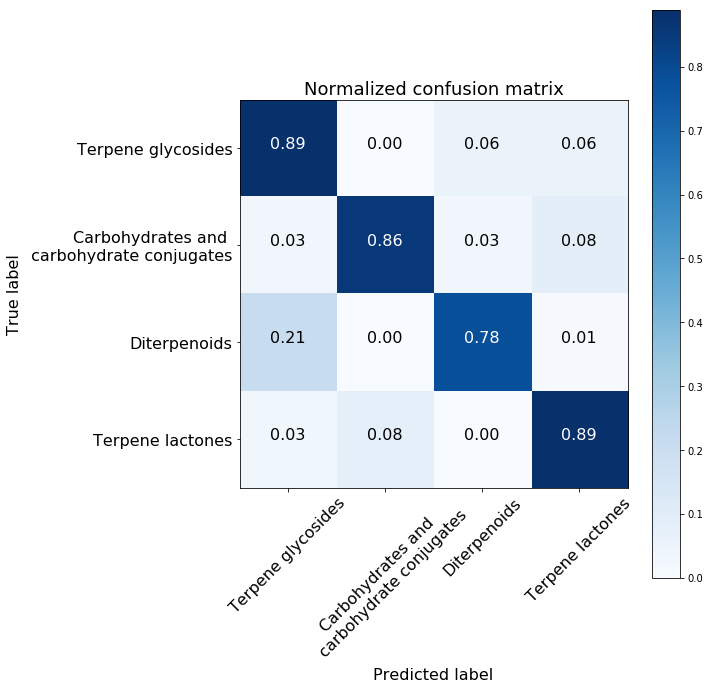

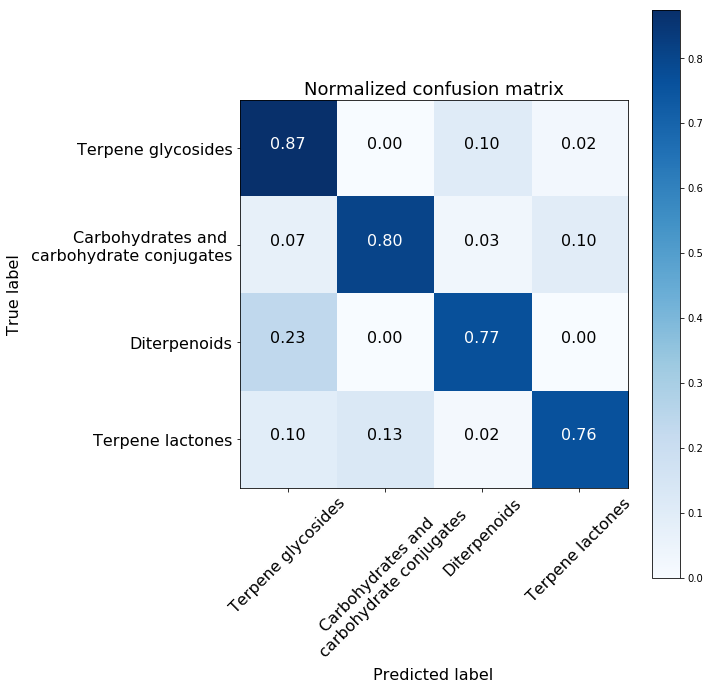

In [11]:
# set name list
for i in [np.argmax((lgb_result) , axis=1),np.argmax((xgb_result) , axis=1)]:
    class_names = list(df.Subclass.value_counts().index)
    class_names[1] = 'Carbohydrates and \n carbohydrate conjugates'

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, i)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

    plt.show()

In [12]:
keras_model  = load_model('../model/Keras_HCD35_pos.h5')
keras_result = keras_model.predict(X_test)
d['Keras'] = [round(keras_model.evaluate(X_test, y_test_for_keras, verbose=0)[1]*100, 2)]

In [13]:
o = {}

In [14]:
o['XGBoost + Ramdom Forest'] = [round((sum(np.argmax((xgb_result+rf_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM'] = [round((sum(np.argmax((xgb_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Keras'] = [round((sum(np.argmax((xgb_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['LightGBM+Keras'] = [round((sum(np.argmax((keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM + Keras'] = [round((sum(np.argmax((keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

In [15]:
b = pd.DataFrame()
b = pd.concat([b, pd.DataFrame(o).T], axis=1)

In [16]:
v = pd.DataFrame()
v = pd.concat([v, pd.DataFrame(d).T], axis=1)

In [17]:
with open('../data/HCD45_pos.pickle', mode='rb') as fp:
    df = pickle.load(fp)

In [18]:
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)

features = df.drop('Subclass', axis=1)

In [19]:
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [20]:
# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [21]:
d = {}

In [22]:
xgb_model = pickle.load(open('../model/xgb_HCD45_pos.sav', 'rb'))
xgb_result = xgb_model.predict_proba(X_test)
print(xgb_model.score(X_test, y_test))
d['Xgboost'] = [round(xgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7827380952380952


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
rf_model = pickle.load(open('../model/rf_HCD45_pos.sav', 'rb'))
rf_result = rf_model.predict_proba(X_test)
print(rf_model.score(X_test, y_test))
d['Random Forest'] = [round(rf_model.score(X_test, y_test)*100, 2)]

0.7083333333333334


In [24]:
lgb_model = pickle.load(open('../model/lgbm_HCD45_pos.sav', 'rb'))
lgb_result = lgb_model.predict_proba(X_test)
print(lgb_model.score(X_test, y_test))
d['LightGBM'] = [round(lgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8125


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [25]:
keras_model  = load_model('../model/Keras_HCD45_pos.h5')
keras_result = keras_model.predict(X_test)
d['Keras'] = [round(keras_model.evaluate(X_test, y_test_for_keras, verbose=0)[1]*100, 2)]

In [26]:
o = {}

In [27]:
o['XGBoost + Ramdom Forest'] = [round((sum(np.argmax((xgb_result+rf_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM'] = [round((sum(np.argmax((xgb_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Keras'] = [round((sum(np.argmax((xgb_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['LightGBM+Keras'] = [round((sum(np.argmax((keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM + Keras'] = [round((sum(np.argmax((keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

In [28]:
b = pd.concat([b, pd.DataFrame(o).T], axis=1)

In [29]:
with open('../data/HCD65_pos.pickle', mode='rb') as fp:
    df = pickle.load(fp)

In [30]:
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)

features = df.drop('Subclass', axis=1)

In [31]:
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [32]:
# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [33]:
d = {}

In [34]:
xgb_model = pickle.load(open('../model/xgb_HCD65_pos.sav', 'rb'))
xgb_result = xgb_model.predict_proba(X_test)
print(xgb_model.score(X_test, y_test))
d['Xgboost'] = [round(xgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7708333333333334


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [35]:
rf_model = pickle.load(open('../model/rf_HCD65_pos.sav', 'rb'))
rf_result = rf_model.predict_proba(X_test)
print(rf_model.score(X_test, y_test))
d['Random Forest'] = [round(rf_model.score(X_test, y_test)*100, 2)]

0.6517857142857143


In [36]:
lgb_model = pickle.load(open('../model/lgbm_HCD65_pos.sav', 'rb'))
lgb_result = lgb_model.predict_proba(X_test)
print(lgb_model.score(X_test, y_test))
d['LightGBM'] = [round(lgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8035714285714286


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [37]:
keras_model  = load_model('../model/Keras_HCD65_pos.h5')
keras_result = keras_model.predict(X_test)
d['Keras'] = [round(keras_model.evaluate(X_test, y_test_for_keras, verbose=0)[1]*100, 2)]

In [38]:
o = {}

In [39]:
o['XGBoost + Ramdom Forest'] = [round((sum(np.argmax((xgb_result+rf_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM'] = [round((sum(np.argmax((xgb_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Keras'] = [round((sum(np.argmax((xgb_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['LightGBM+Keras'] = [round((sum(np.argmax((keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM + Keras'] = [round((sum(np.argmax((keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

In [40]:
b = pd.concat([b, pd.DataFrame(o).T], axis=1)

In [41]:
with open('../data/HCD35_neg.pickle', mode='rb') as fp:
    df = pickle.load(fp)

In [42]:
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)

features = df.drop('Subclass', axis=1)

In [43]:
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [44]:
# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [45]:
d = {}

In [46]:
xgb_model = pickle.load(open('../model/xgb_HCD35_neg.sav', 'rb'))
xgb_result = xgb_model.predict_proba(X_test)
print(xgb_model.score(X_test, y_test))
d['Xgboost'] = [round(xgb_model.score(X_test, y_test)*100, 2)]

0.776595744680851


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [47]:
rf_model = pickle.load(open('../model/rf_HCD35_neg.sav', 'rb'))
rf_result = rf_model.predict_proba(X_test)
print(rf_model.score(X_test, y_test))
d['Random Forest'] = [round(rf_model.score(X_test, y_test)*100, 2)]

0.7127659574468085


In [48]:
lgb_model = pickle.load(open('../model/lgbm_HCD35_neg.sav', 'rb'))
lgb_result = lgb_model.predict_proba(X_test)
print(lgb_model.score(X_test, y_test))
d['LightGBM'] = [round(lgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7340425531914894


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [49]:
keras_model  = load_model('../model/Keras_HCD35_neg.h5')
keras_result = keras_model.predict(X_test)
d['Keras'] = [round(keras_model.evaluate(X_test, y_test_for_keras, verbose=0)[1]*100, 2)]

In [50]:
o = {}

In [51]:
o['XGBoost + Ramdom Forest'] = [round((sum(np.argmax((xgb_result+rf_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM'] = [round((sum(np.argmax((xgb_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Keras'] = [round((sum(np.argmax((xgb_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['LightGBM+Keras'] = [round((sum(np.argmax((keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM + Keras'] = [round((sum(np.argmax((keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

In [52]:
b = pd.concat([b, pd.DataFrame(o).T], axis=1)

In [53]:
with open('../data/HCD45_neg.pickle', mode='rb') as fp:
    df = pickle.load(fp)

In [54]:
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)

features = df.drop('Subclass', axis=1)

In [55]:
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [56]:
# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [57]:
d = {}

In [58]:
xgb_model = pickle.load(open('../model/xgb_HCD45_neg.sav', 'rb'))
xgb_result = xgb_model.predict_proba(X_test)
print(xgb_model.score(X_test, y_test))
d['Xgboost'] = [round(xgb_model.score(X_test, y_test)*100, 2)]

0.723404255319149


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [59]:
rf_model = pickle.load(open('../model/rf_HCD45_neg.sav', 'rb'))
rf_result = rf_model.predict_proba(X_test)
print(rf_model.score(X_test, y_test))
d['Random Forest'] = [round(rf_model.score(X_test, y_test)*100, 2)]

0.6702127659574468


In [60]:
lgb_model = pickle.load(open('../model/lgbm_HCD45_neg.sav', 'rb'))
lgb_result = lgb_model.predict_proba(X_test)
print(lgb_model.score(X_test, y_test))
d['LightGBM'] = [round(lgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7021276595744681


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [61]:
keras_model  = load_model('../model/Keras_HCD45_neg.h5')
keras_result = keras_model.predict(X_test)
d['Keras'] = [round(keras_model.evaluate(X_test, y_test_for_keras, verbose=0)[1]*100, 2)]

In [62]:
o = {}

In [63]:
o['XGBoost + Ramdom Forest'] = [round((sum(np.argmax((xgb_result+rf_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM'] = [round((sum(np.argmax((xgb_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Keras'] = [round((sum(np.argmax((xgb_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['LightGBM+Keras'] = [round((sum(np.argmax((keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM + Keras'] = [round((sum(np.argmax((keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

In [64]:
b = pd.concat([b, pd.DataFrame(o).T], axis=1)

In [65]:
with open('../data/HCD65_neg.pickle', mode='rb') as fp:
    df = pickle.load(fp)

In [66]:
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)

features = df.drop('Subclass', axis=1)

In [67]:
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [68]:
# transform  for keras's target label
y_train_for_keras = np_utils.to_categorical(y_train)
y_test_for_keras = np_utils.to_categorical(y_test)

In [69]:
d = {}

In [70]:
xgb_model = pickle.load(open('../model/xgb_HCD65_neg.sav', 'rb'))
xgb_result = xgb_model.predict_proba(X_test)
print(xgb_model.score(X_test, y_test))
d['Xgboost'] = [round(xgb_model.score(X_test, y_test)*100, 2)]

0.7446808510638298


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [71]:
rf_model = pickle.load(open('../model/rf_HCD65_neg.sav', 'rb'))
rf_result = rf_model.predict_proba(X_test)
print(rf_model.score(X_test, y_test))
d['Random Forest'] = [round(rf_model.score(X_test, y_test)*100, 2)]

0.648936170212766


In [72]:
lgb_model = pickle.load(open('../model/lgbm_HCD65_neg.sav', 'rb'))
lgb_result = lgb_model.predict_proba(X_test)
print(lgb_model.score(X_test, y_test))
d['LightGBM'] = [round(lgb_model.score(X_test, y_test)*100, 2)]

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6808510638297872


/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [73]:
keras_model  = load_model('../model/Keras_HCD65_neg.h5')
keras_result = keras_model.predict(X_test)
d['Keras'] = [round(keras_model.evaluate(X_test, y_test_for_keras, verbose=0)[1]*100, 2)]

In [74]:
o = {}

In [75]:
o['XGBoost + Ramdom Forest'] = [round((sum(np.argmax((xgb_result+rf_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM'] = [round((sum(np.argmax((xgb_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Keras'] = [round((sum(np.argmax((xgb_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['LightGBM+Keras'] = [round((sum(np.argmax((keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM'] = [round((sum(np.argmax((rf_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + Random Forest + Keras'] = [round((sum(np.argmax((rf_result+keras_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['XGBoost + LightGBM + Keras'] = [round((sum(np.argmax((keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]
o['Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

o['XGBoost + Random Forest + LightGBM + Keras'] = [round((sum(np.argmax((rf_result+keras_result+lgb_result+xgb_result) , axis=1) == y_test)/len(y_test))*100, 2)]

In [76]:
b = pd.concat([b, pd.DataFrame(o).T], axis=1)
b.columns = [
    'HCD35_Positive', 'HCD45_Positive', 'HCD65_Positive',
    'HCD35_Negative', 'HCD45_Negative', 'HCD65_Negative',
]

v = pd.concat([v, pd.DataFrame(d).T], axis=1)

In [77]:
v

,0,0
Xgboost,80.06,74.47
Random Forest,71.73,64.89
LightGBM,84.52,68.09
Keras,68.45,65.96


In [77]:
b.to_csv('../result/voting.csv')

,HCD35_Positive,HCD45_Positive,HCD65_Positive,HCD35_Negative,HCD45_Negative,HCD65_Negative
XGBoost + Ramdom Forest,79.46,77.68,76.79,76.60,74.47,73.40
XGBoost + LightGBM,84.52,81.85,80.36,76.60,71.28,72.34
XGBoost + Keras,80.65,78.57,79.46,79.79,70.21,72.34
Random Forest + LightGBM,80.65,80.36,78.87,74.47,76.60,72.34
Random Forest + Keras,76.19,72.62,74.40,71.28,71.28,71.28
LightGBM+Keras,82.14,80.95,79.76,74.47,72.34,69.15
XGBoost + Random Forest + LightGBM,82.44,80.95,78.57,78.72,72.34,71.28
XGBoost + Random Forest + Keras,82.14,77.98,80.06,75.53,74.47,74.47
XGBoost + LightGBM + Keras,84.23,81.85,80.95,80.85,73.40,75.53
Random Forest + LightGBM + Keras,83.63,79.17,80.06,75.53,73.40,69.15
